In [1]:
import pandas as pd
import numpy as np

# utils
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# nlp
import spacy
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

# machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bambr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('Phishing_Email.csv')

data

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email


In [3]:
data.shape

(18650, 3)

In [4]:
data.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [5]:
## Cleaning

# dropping nulls
data = data.dropna()

# specific doc that is incredible large
data = data.drop(index=12500)

# unecessary column
data = data.drop(columns=['Unnamed: 0'])

# cleaning text feature
data['Email Text'] = data['Email Text'].str.replace('\n', ' ')
data['Email Text'] = data['Email Text'].str.replace(r'\s\\', '')

# adding binary representation of target
data['binary_target'] = data['Email Type'].map({'Phishing Email': 1, 'Safe Email': 0})

data

,Email Text,Email Type,binary_target
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0
1,the other side of * galicismos * * galicismo *...,Safe Email,0
2,re : equistar deal tickets are you still avail...,Safe Email,0
3,Hello I am your hot lil horny toy. I am t...,Phishing Email,1
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1
...,...,...,...
18645,date a lonely housewife always wanted to date ...,Phishing Email,1
18646,request submitted : access request for anita ....,Safe Email,0
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email,0
18648,press clippings - letter on californian utilit...,Safe Email,0


In [6]:
data.shape

(18633, 3)

In [7]:
## NLP

nlp = spacy.load('en_core_web_sm')
docs = data['Email Text'].values.tolist()

nlp_docs = [nlp(doc) for doc in tqdm(docs)]

  0%|          | 0/18633 [00:00<?, ?it/s]

In [8]:
df = data.copy()

In [9]:
## Feature Engineering: Tokens statistics

tokens_statistics = [
    (
        len(doc), # how many tokens
        len([token for token in doc if token.is_alpha]), # how many words
        len([token for token in doc if (token.is_alpha) and (len(wn.synsets(token.text)) > 0)]), # how many recognizable words
        len([token for token in doc if token.is_punct]), # how many special chars tokens
        len([token for token in doc if token.like_email]), # how many email tokens
        len([token for token in doc if token.like_url]) # how many url tokens
    ) for doc in tqdm(nlp_docs)
]

tokens_stats_df = pd.DataFrame(tokens_statistics, columns=['tokens_len', 'tokens_words', 'tokens_real_words', 'tokens_special', 'tokens_email', 'tokens_url'])

# augmenting base dataframe
df['tokens_len'] = tokens_stats_df['tokens_len'].values
df['tokens_words_perc'] = (tokens_stats_df['tokens_words'] / tokens_stats_df['tokens_len']).values
df['tokens_real_words_perc'] = (tokens_stats_df['tokens_real_words'] / tokens_stats_df['tokens_words']).values
df['tokens_special_perc'] = (tokens_stats_df['tokens_special'] / tokens_stats_df['tokens_len']).values
df['has_email'] = (tokens_stats_df['tokens_email'] > 0).values
df['has_url'] = ((tokens_stats_df['tokens_url'] > 0)).values

df

  0%|          | 0/18633 [00:00<?, ?it/s]

,Email Text,Email Type,binary_target,tokens_len,tokens_words_perc,tokens_real_words_perc,tokens_special_perc,has_email,has_url
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0,232,0.724138,0.779762,0.228448,False,False
1,the other side of * galicismos * * galicismo *...,Safe Email,0,91,0.802198,0.616438,0.175824,False,False
2,re : equistar deal tickets are you still avail...,Safe Email,0,305,0.600000,0.644809,0.314754,False,False
3,Hello I am your hot lil horny toy. I am t...,Phishing Email,1,194,0.479381,0.752688,0.381443,False,True
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1,91,0.692308,0.984127,0.296703,False,False
...,...,...,...,...,...,...,...,...,...
18645,date a lonely housewife always wanted to date ...,Phishing Email,1,45,0.800000,0.750000,0.200000,False,False
18646,request submitted : access request for anita ....,Safe Email,0,100,0.620000,0.629032,0.310000,False,False
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email,0,253,0.841897,0.685446,0.158103,False,False
18648,press clippings - letter on californian utilit...,Safe Email,0,34,0.764706,0.846154,0.235294,False,False


C:\Users\bambr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bambr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


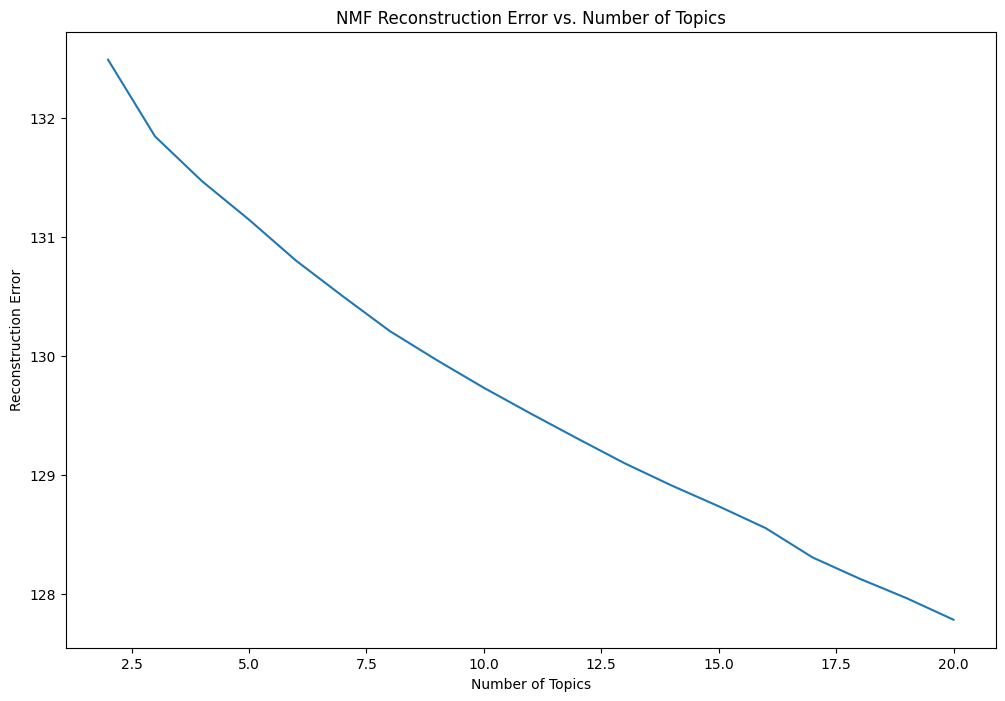

In [10]:
## Topic Analysis

def preprocess_email(doc):
    return " ".join([token.lemma_ for token in doc if (not token.is_stop) and (token.is_alpha) and (len(token) > 2)])

processed_emails = [preprocess_email(doc) for doc in nlp_docs]

# applying TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(processed_emails)

# function to calculate NMF model for a given number of topics and return the reconstruction error
def calculate_nmf(num_topics, tfidf_matrix):
    nmf_model = NMF(n_components=num_topics, random_state=1)
    nmf_model.fit(tfidf_matrix)
    return nmf_model.reconstruction_err_

# evaluating the number of topics
topic_range = range(2, 21) 
reconstruction_errors = [calculate_nmf(i, tfidf) for i in topic_range]

# plotting the results
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.lineplot(x=topic_range, y=reconstruction_errors)
_ = ax.set_xlabel("Number of Topics")
_ = ax.set_ylabel("Reconstruction Error")
_ = ax.set_title("NMF Reconstruction Error vs. Number of Topics")

In [11]:
# applying NMF model
num_topics = 6  # chosen accordingly the evaluation before
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)

# evaluating topics and top words
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

n_top_words = 10 
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), n_top_words)

Topic 0:
enron hpl com gas vince teco corp xls energy tap
Topic 1:
ect hou vince enron subject kaminski lon meter deal corp
Topic 2:
hourahead schedule date hour start variance ancillary westdesk detect txt
Topic 3:
language university linguistic paper conference abstract workshop edu english submission
Topic 4:
click free company email business money receive com order remove
Topic 5:
list mailing linux razor rpm email spam write spamassassin message


In [12]:
# augmenting the base dataframe
df['topic'] = [doc.argmax() for doc in nmf_topics]

df

,Email Text,Email Type,binary_target,tokens_len,tokens_words_perc,tokens_real_words_perc,tokens_special_perc,has_email,has_url,topic
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0,232,0.724138,0.779762,0.228448,False,False,4
1,the other side of * galicismos * * galicismo *...,Safe Email,0,91,0.802198,0.616438,0.175824,False,False,3
2,re : equistar deal tickets are you still avail...,Safe Email,0,305,0.600000,0.644809,0.314754,False,False,1
3,Hello I am your hot lil horny toy. I am t...,Phishing Email,1,194,0.479381,0.752688,0.381443,False,True,4
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1,91,0.692308,0.984127,0.296703,False,False,4
...,...,...,...,...,...,...,...,...,...,...
18645,date a lonely housewife always wanted to date ...,Phishing Email,1,45,0.800000,0.750000,0.200000,False,False,2
18646,request submitted : access request for anita ....,Safe Email,0,100,0.620000,0.629032,0.310000,False,False,0
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email,0,253,0.841897,0.685446,0.158103,False,False,0
18648,press clippings - letter on californian utilit...,Safe Email,0,34,0.764706,0.846154,0.235294,False,False,0


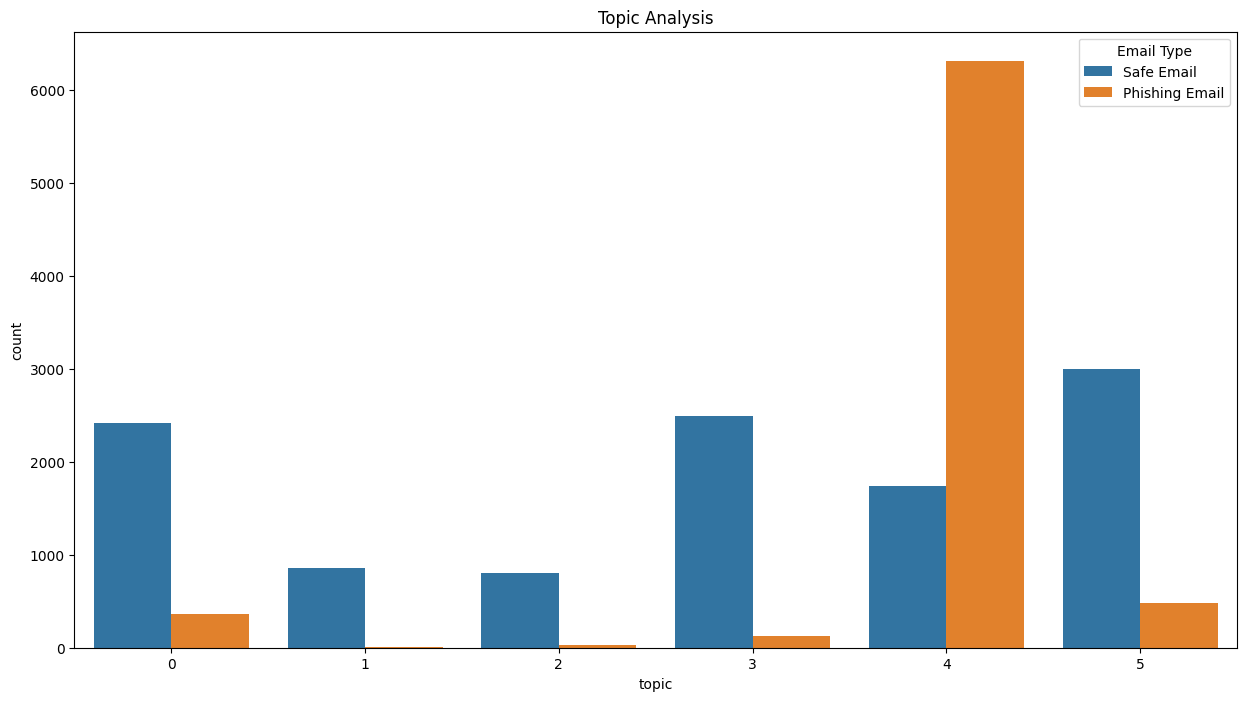

In [13]:
## EDA

fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.countplot(x='topic', hue='Email Type', data=df)
_ = ax.set_title('Topic Analysis')

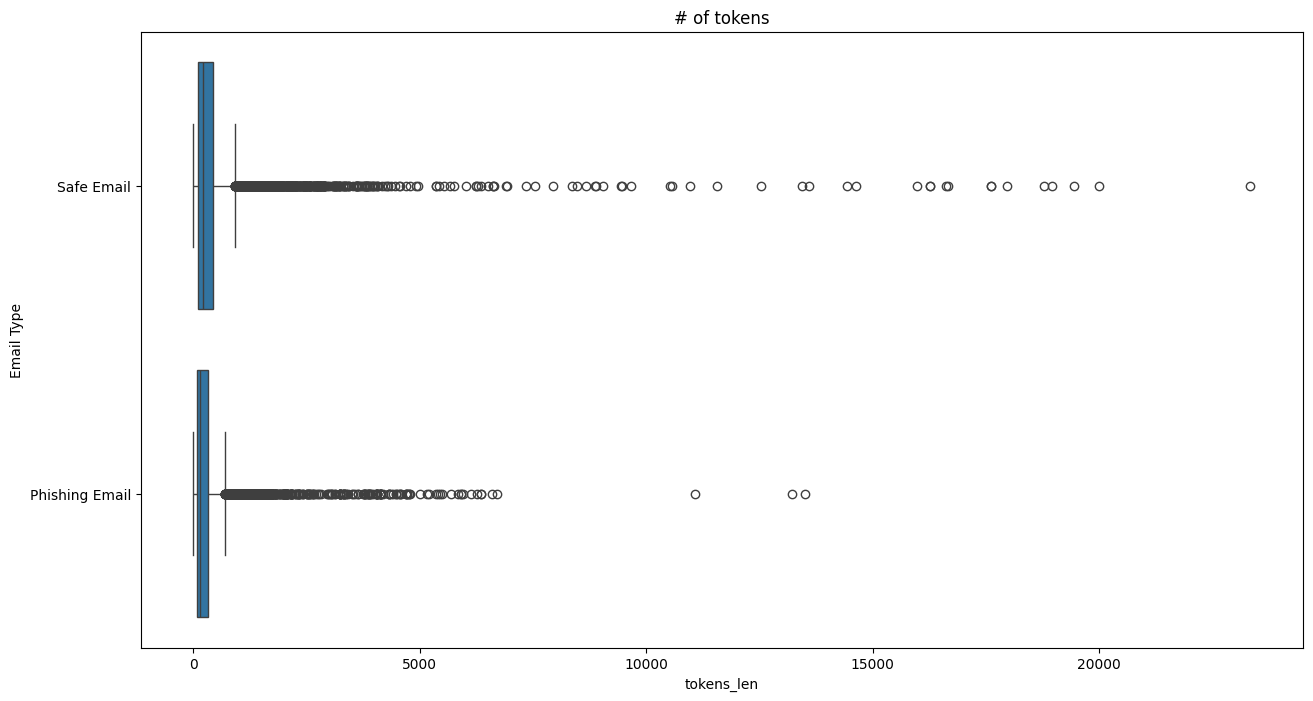

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.boxplot(x='tokens_len', y='Email Type', data=df)
_ = ax.set_title('# of tokens')

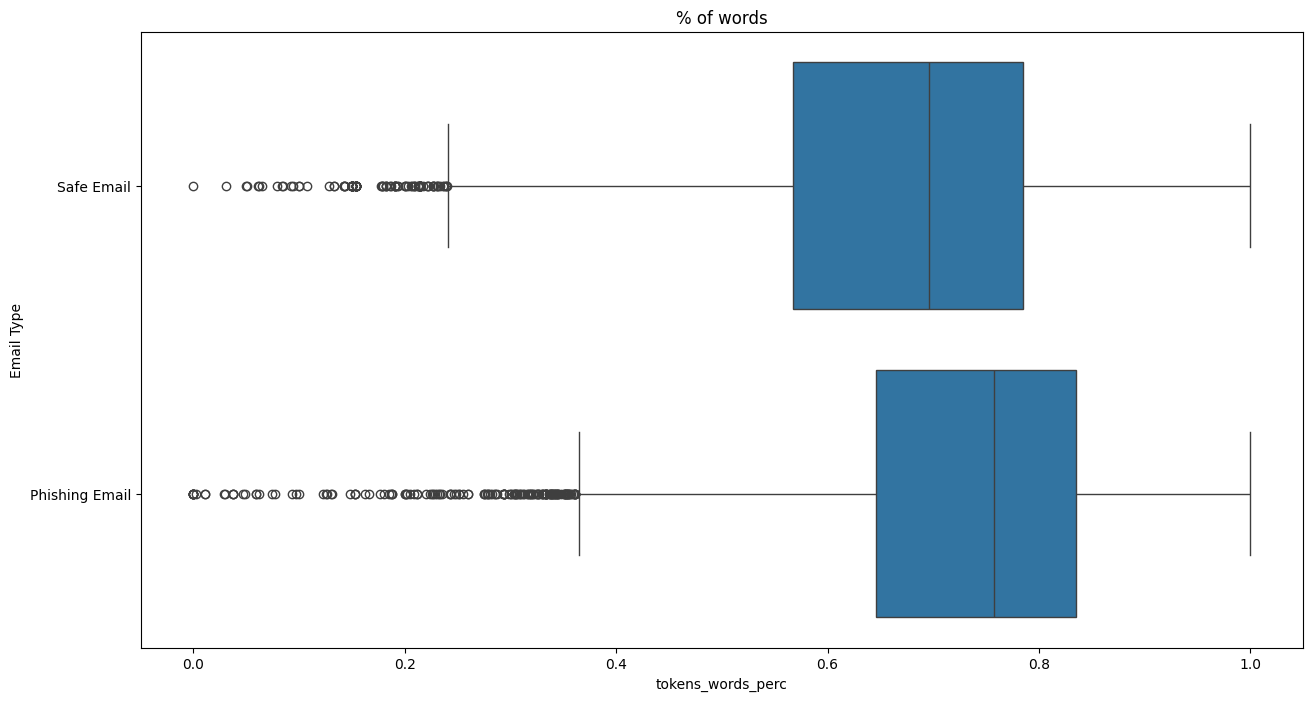

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.boxplot(x='tokens_words_perc', y='Email Type', data=df)
_ = ax.set_title('% of words')

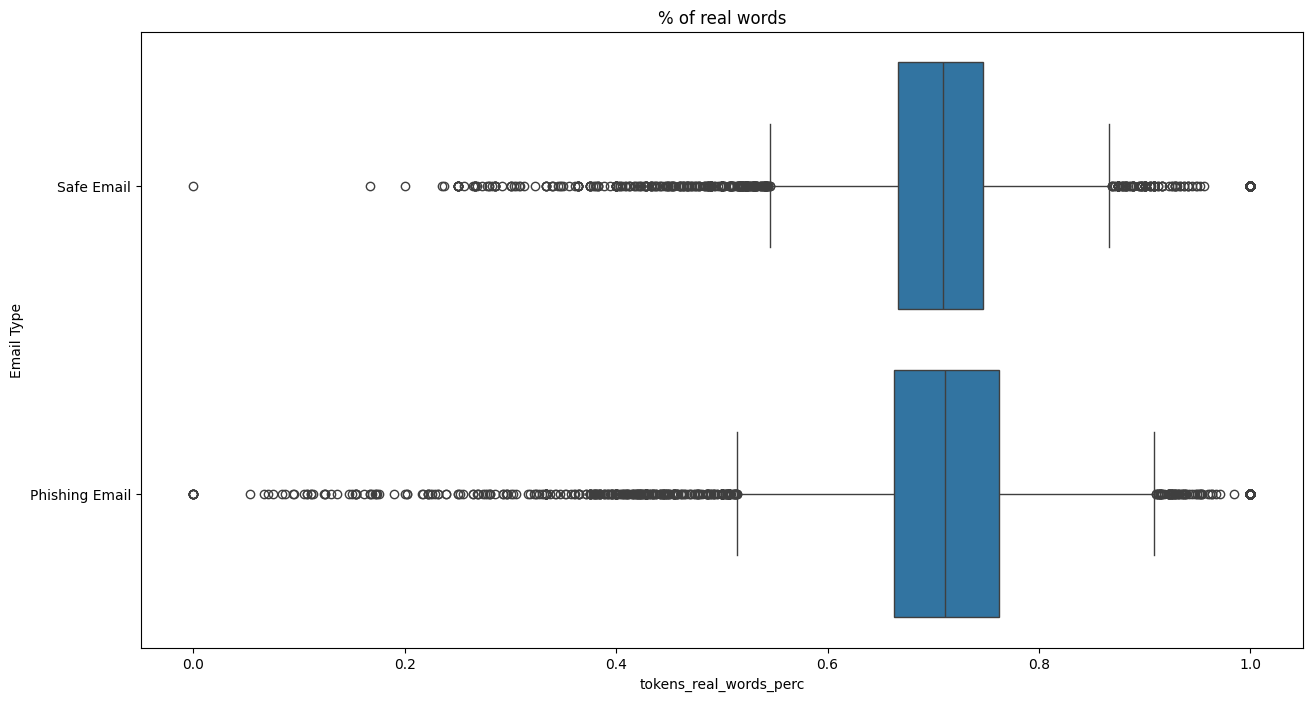

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.boxplot(x='tokens_real_words_perc', y='Email Type', data=df)
_ = ax.set_title('% of real words')

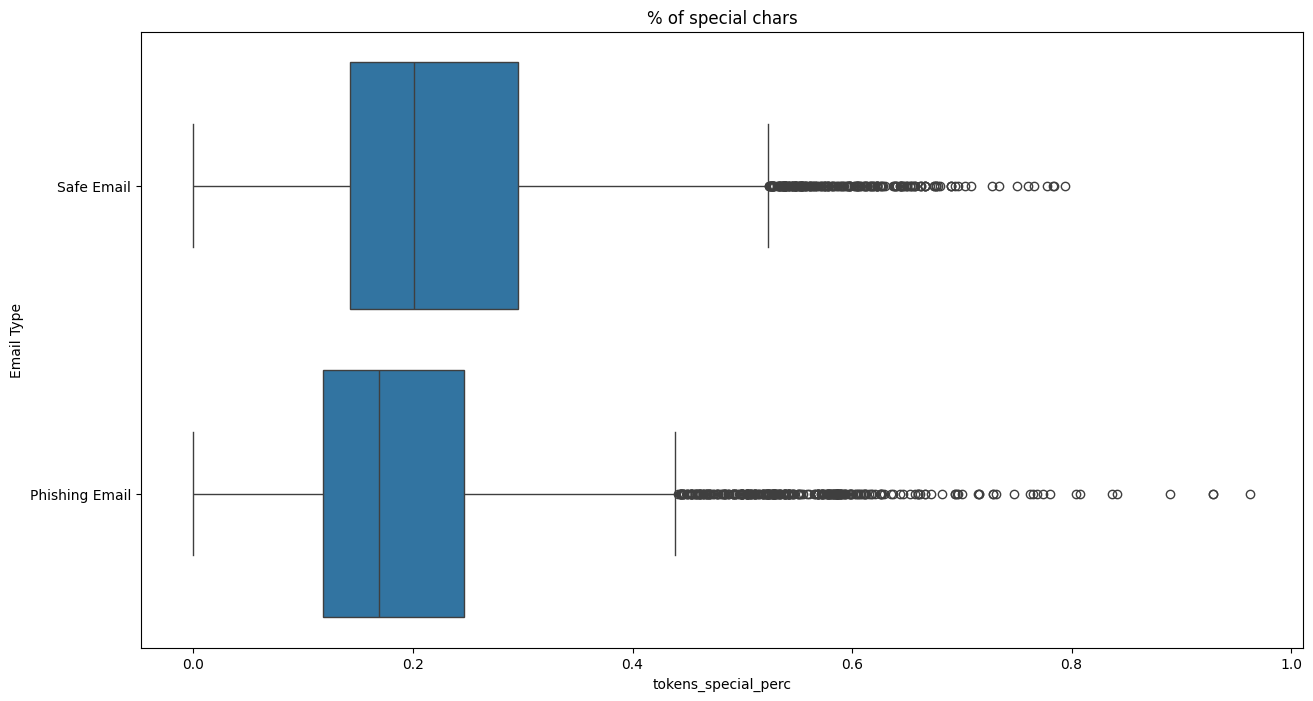

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.boxplot(x='tokens_special_perc', y='Email Type', data=df)
_ = ax.set_title('% of special chars')

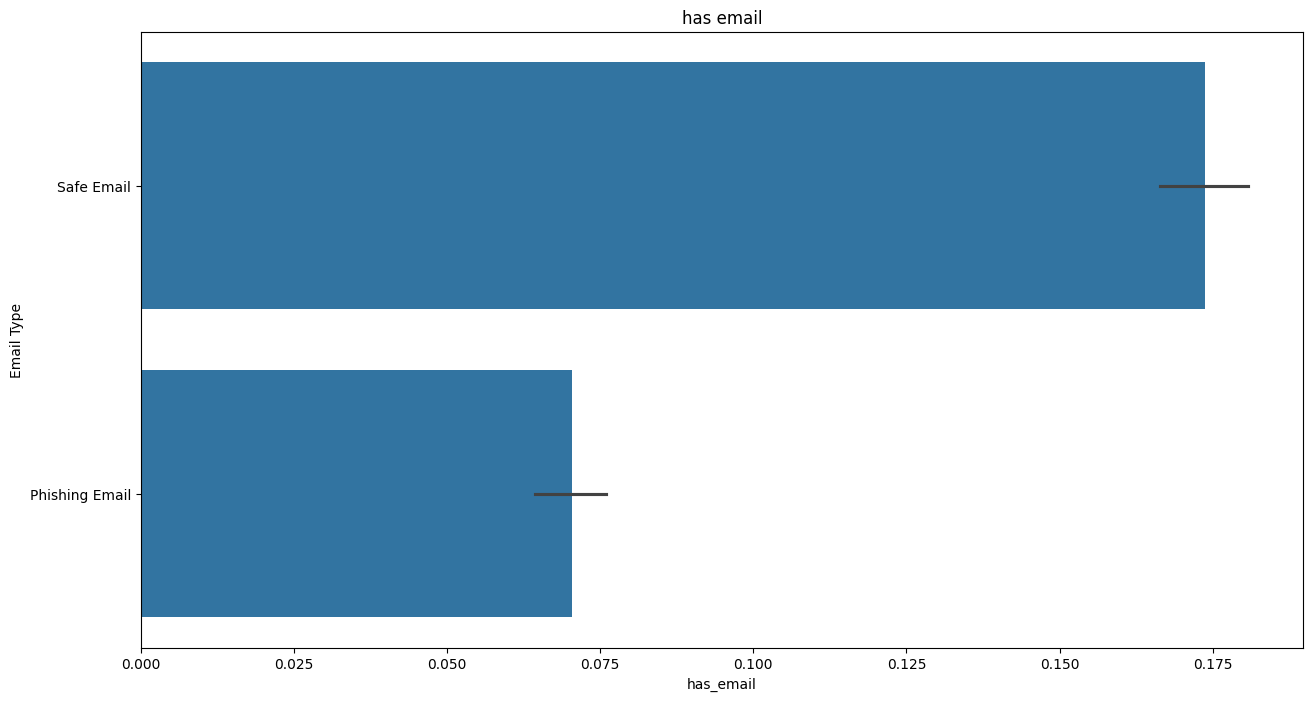

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.barplot(x='has_email', y='Email Type', data=df)
_ = ax.set_title('has email')

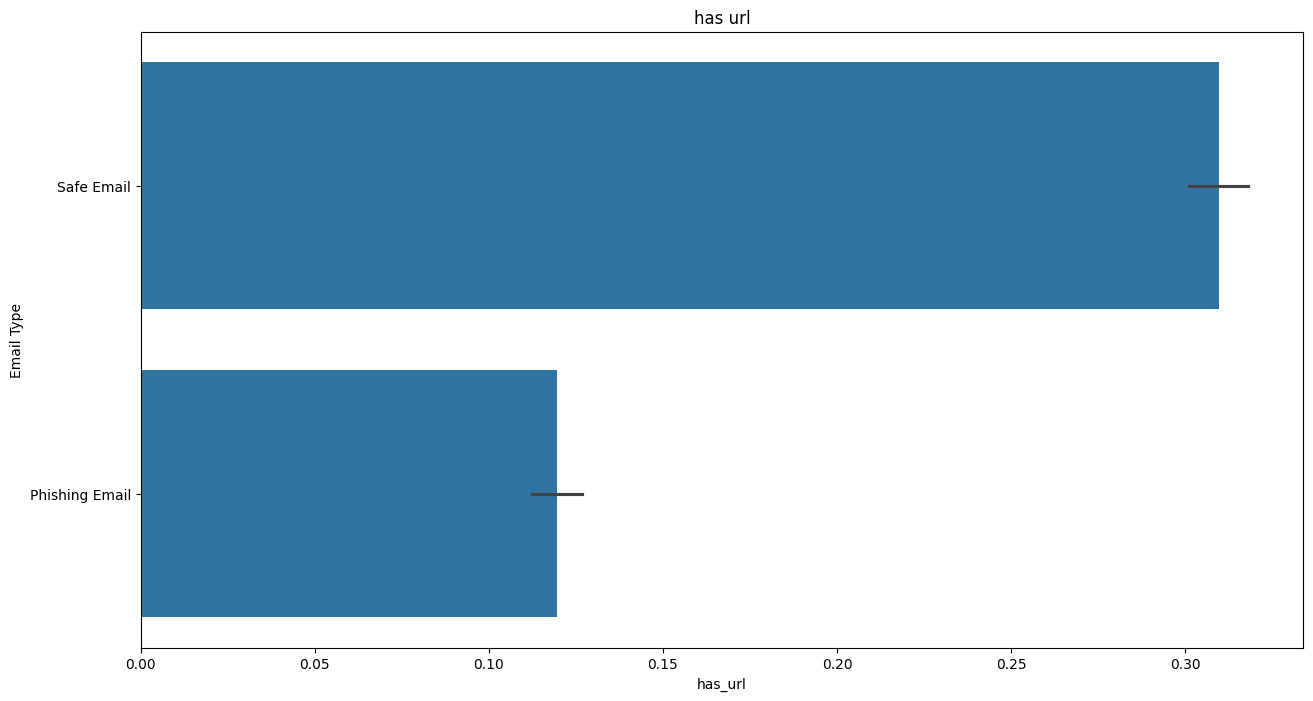

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.barplot(x='has_url', y='Email Type', data=df)
_ = ax.set_title('has url')

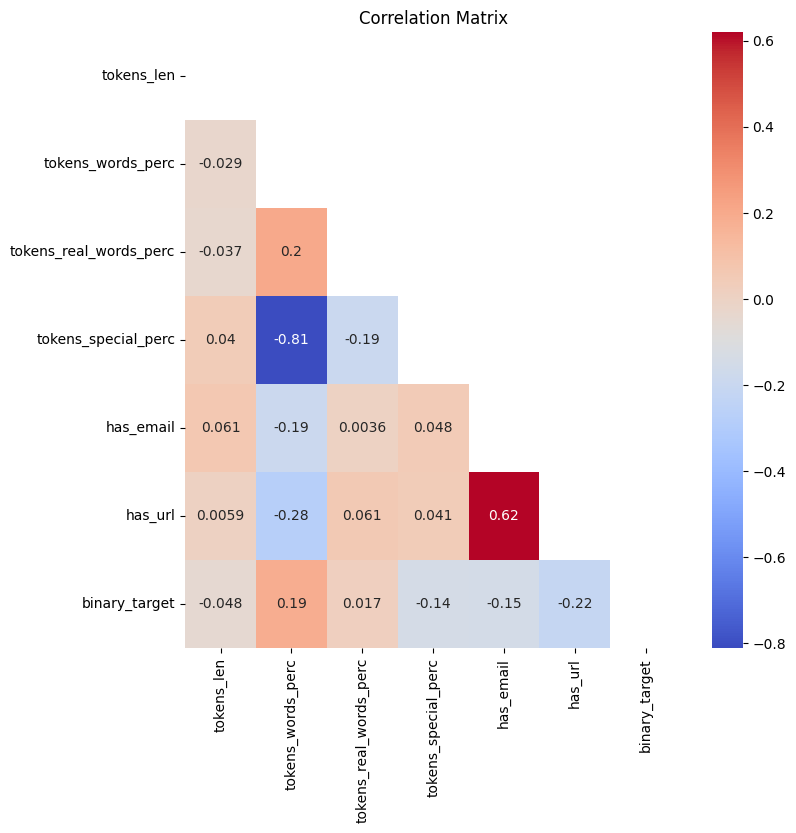

In [20]:
corr = df[['tokens_len', 'tokens_words_perc', 'tokens_real_words_perc', 'tokens_special_perc', 'has_email', 'has_url', 'binary_target']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask)

_ = ax.set_title('Correlation Matrix')
#_ = ax.set_xticks(rotation=45)
#_ = ax.set_yticks(rotation=45)


## Conclusion
The analysis of the topics revealed that the majority of phishing emails were grouped into a single category, indicating that the email content is a significant indicator of phishing attempts. In contrast, the features derived from token statistics did not provide meaningful insights; they lacked the predictive strength demonstrated by the topic analysis. It's important to note that these findings are specific to the dataset utilized in this project.